<a href="https://colab.research.google.com/github/kdambrowski/News_clasyfication/blob/main/Updated_Fake_news_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1 Fake News Classification

## WELFake_Dataset

About Dataset
(WELFake) is a dataset of 72,134 news articles with 35,028 real and 37,106 fake news. For this, authors merged four popular news datasets (i.e. Kaggle, McIntire, Reuters, BuzzFeed Political) to prevent over-fitting of classifiers and to provide more text data for better ML training.

Dataset contains four columns: Serial number (starting from 0); Title (about the text news heading); Text (about the news content); and Label (0 = fake and 1 = real).

There are 78098 data entries in csv file out of which only 72134 entries are accessed as per the data frame.

Published in:
IEEE Transactions on Computational Social Systems: pp. 1-13 (doi: 10.1109/TCSS.2021.3068519).

##fake-and-real-news-dataset

About Dataset.
Ahmed H, Traore I, Saad S. “Detecting opinion spams and fake news using text classification”, Journal of Security and Privacy, Volume 1, Issue 1, Wiley, January/February 2018.
Ahmed H, Traore I, Saad S. (2017) “Detection of Online Fake News Using N-Gram Analysis and Machine Learning Techniques. In: Traore I., Woungang I., Awad A. (eds) Intelligent, Secure, and Dependable Systems in Distributed and Cloud Environments. ISDDC 2017. Lecture Notes in Computer Science, vol 10618. Springer, Cham (pp. 127-138).
Inspiration
Can you use this data set to make an algorithm able to determine if an article is fake news or not ?

## FakeNewsNet



About Dataset
This dataset contains news articles and information about it.

Original: FakeNewsNet.

Context
All data is got from FakeNewsNet.
The data was cleaned and combined in one file. Some columns were changed.
You can see preprocessing algorithm here.

#PiP installation

In [ ]:
! pip install -q kaggle

In [ ]:
!pip install -q --upgrade pip

In [ ]:
!pip install validators -q

In [ ]:
!pip install neattext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q torch

# DS's download

To download DS's from kaggle do you will need kaggle access token.
There you have a instruction how to do this
[Kaggle_DS's_download_instruction](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

## Create dictionary in root and copy file with kaggle acconut token to created dictionary

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/Colab_Notebooks/Upskill/News_classyfication/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


## Using kaggle API to download DS's to colab enviroment

In [ ]:
!kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset
!kaggle datasets download -d algord/fake-news
!kaggle datasets download -d saurabhshahane/fake-news-classification

100% 41.0M/41.0M [00:02<00:00, 26.5MB/s]
100% 41.0M/41.0M [00:02<00:00, 18.1MB/s]
 60% 1.00M/1.68M [00:00<00:00, 1.45MB/s]
100% 1.68M/1.68M [00:00<00:00, 2.17MB/s]
 98% 90.0M/92.1M [00:05<00:00, 17.3MB/s]
100% 92.1M/92.1M [00:05<00:00, 17.8MB/s]


## Unzip files

In [ ]:
! unzip /content/fake-and-real-news-dataset.zip
! unzip /content/fake-news-classification.zip
! unzip /content/fake-news.zip

Archive:  /content/fake-and-real-news-dataset.zip
  inflating: Fake.csv                
  inflating: True.csv                
Archive:  /content/fake-news-classification.zip
  inflating: WELFake_Dataset.csv     
Archive:  /content/fake-news.zip
  inflating: FakeNewsNet.csv         


# Library

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
import neattext.functions as nfx
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk import sent_tokenize, word_tokenize
from tqdm import tqdm, tqdm_notebook

# Classes and functions

In [ ]:
class Sequences(Dataset):
    def __init__(self, df, raw_text, label):
        self.vectorizer = CountVectorizer(stop_words='english', max_df=0.99, min_df=0.005)
        self.sequences = self.vectorizer.fit_transform(df[raw_text].tolist())
        self.labels = df[label].tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
        
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]


class BagOfWordsClassifier(nn.Module):
    def __init__(self, vocab_size, hidden1, hidden2):
        super(BagOfWordsClassifier, self).__init__()
        self.fc1 = nn.Linear(vocab_size, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, 1)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def text_low_standarization(ds):
  for col in ds.select_dtypes('object'):
    ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')
    ds.loc[:,(col)]= ds.loc[:,(col)].apply(lambda x: x.lower())
  return ds

def display_class_pie_distribution(ds, label_col_name):
  plt.pie(ds[label_col_name].value_counts(normalize=True),
          labels=set(ds[label_col_name]),
          autopct='%1.2f%%')
  plt.title(f'{label_col_name} distribution')
  plt.show()

def min_column_len_filter(ds, col, len):
  len_filter = ds[col].str.len()>len
  ds = ds[len_filter]
  return ds

def is_null_filter(ds):
  is_null_filter = ds.isnull().sum(axis=1).astype(bool)
  return is_null_filter

def ds_wo_null(ds):
  filter = is_null_filter(ds)
  ds= ds[~filter]
  return ds

def result_m(ds, text_column_name, nfx, list_of_nfx_methods):
    for stuff in dir(nfx):
      for method in list_of_nfx_methods:
        if stuff == method:
          ds[[text_column_name]] = ds[[text_column_name]].apply(stuff)
    return ds

dir(nfx)
def clean_text_by_nfx_filter(ds, text_column_name):
    ds['clean_text'] = ds[text_column_name]
    ds['clean_text'] = ds['clean_text'].apply(nfx.fix_contractions)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_userhandles)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_special_characters)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_emails)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_numbers)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_urls)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_emojis)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_stopwords)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_multiple_spaces)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_currency_symbols)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_puncts)
    ds['clean_text'] = ds['clean_text'].apply(nfx.remove_shortwords)
    return ds

def change_col_to_string(ds, dtype_of_col = 'object'):
    for col in ds.select_dtypes(dtype_of_col):
        ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')
    return ds.info()

def conv_tag(tag: str):
  conv_dict = {'NN': 'n',
             'VB' : 'v',
             'JJ' : 'a',
             'RB' : 'r'} 
  ctag = conv_dict.get(tag[:2])
  if ctag:
    return ctag
  else:
    return 'n'
  return conv_dict[tag[:2]]

def lemmatize_sent(text: str) -> list:
  return [wnl.lemmatize(word.lower(), pos=conv_tag(tag)) 
          for word, tag in pos_tag(word_tokenize(text))]

def process_text(text: str) -> list:
  return [word for word in lemmatize_sent(text) 
          if word not in stopwords_en 
             and not word.isdigit()]

def print_predict_news_autentication(text, model, sequenced_train_dataset):
    model.eval()
    if type(text) != 'str':
      str_text = text.to_string()
      with torch.no_grad():

        test_vector = torch.LongTensor(sequenced_train_dataset.
                                       vectorizer.
                                       transform([str_text]).
                                       toarray())

        output = model(test_vector)
        prediction = torch.sigmoid(output).item()

        if prediction > 0.5:
            print(f'Conficence of prediction: {prediction*100:0.3}% \nReal news')
        else:
            print(f'Conficence of prediction: {(1-prediction)*100:0.3}% \nFake news')
    else:
      with torch.no_grad():

          test_vector = torch.LongTensor(dataset.vectorizer.transform([text]).toarray())

          output = model(test_vector)
          prediction = torch.sigmoid(output).item()

          if prediction > 0.5:
              print(f'{prediction:0.3}: Real news')
          else:
              print(f'{prediction:0.3}: Fake news')

def training_pt_model(model, train_loader, criterion, optimizer, epochs = 10):
  model.train()
  train_losses = []
  for epoch in range(epochs):
    progress_bar = tqdm_notebook(train_loader, leave=False)
    losses = []
    total = 0
    for inputs, target in progress_bar:
      model.zero_grad()
      output = model(inputs)  # to jest y_pred
      loss = criterion(output.squeeze(), target.float())
      loss.backward()              
      nn.utils.clip_grad_norm_(model.parameters(), 3)
      optimizer.step()

      progress_bar.set_description(f'Loss: {loss.item():.3f}')

      losses.append(loss.item())
      total += 1

    epoch_loss = sum(losses) / total
    train_losses.append(epoch_loss)

    tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.5f}')

def print_news_autentication_predict_ml(CV_from_model, text_to_pred, trained_model):
  text_encoded = CV_from_model.transform(text_to_pred)
  text_pred = trained_model.predict(text_encoded)
  prob = trained_model.predict_proba(text_encoded)

  if len(text_to_pred) > 20:
    text_sample = round(len(text_to_pred)*0.1)
  else:
    text_sample = len(text_to_pred)
  if text_pred[0]:
    print(f'Tested text: "{text_to_pred[:text_sample].to_string()}..." \n\nNEWS IS REAL \nwith confidence: {prob[0,1]*100:.3f}%')
  else:
    print(f'Tested text: "{text_to_pred[:text_sample].to_string()}..." \n\nNEWS IS FAKE \nwith confidence: {prob[0,0]*100:.3f}%')

# Settings and variables 

In [ ]:
wel_fake_ds_path ='/content/WELFake_Dataset.csv'
fake_news_path = '/content/Fake.csv'
true_news_path = "/content/True.csv"
fake_news_net_path = '/content/FakeNewsNet.csv'
page_up = '/content/drive/MyDrive/Colab_Notebooks/Upskill/News_classyfication/url_with_code_200.csv'

null_rows_threshold = 0.1
words_len = 10

nltk.download('stopwords')
stopwords_en = stopwords.words('english')

nltk.download('wordnet')
nltk.download('omw-1.4')
wnl = WordNetLemmatizer()

nltk.download('averaged_perceptron_tagger')

nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## DF1 (fake-and-real-news-dataset)

In [ ]:
fake_news = pd.read_csv(fake_news_path)
true_news = pd.read_csv(true_news_path)
fake_news['label'] = np.zeros(len(fake_news.index))
true_news['label'] = np.ones(len(true_news.index))
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    23481 non-null  object 
 1   text     23481 non-null  object 
 2   subject  23481 non-null  object 
 3   date     23481 non-null  object 
 4   label    23481 non-null  float64
dtypes: float64(1), object(4)
memory usage: 917.4+ KB


In [ ]:
fake_news.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
true_news.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
merged_fake_ture_ds = pd.concat([true_news,fake_news], axis=0)
merged_fake_ture_ds = merged_fake_ture_ds.reset_index(drop=True)
merged_fake_ture_ds

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1.0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1.0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1.0
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1.0
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1.0
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0.0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0.0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0.0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0.0


In [ ]:
len_check_merged_fake_true_ds = min_column_len_filter(merged_fake_ture_ds, 'text', words_len)

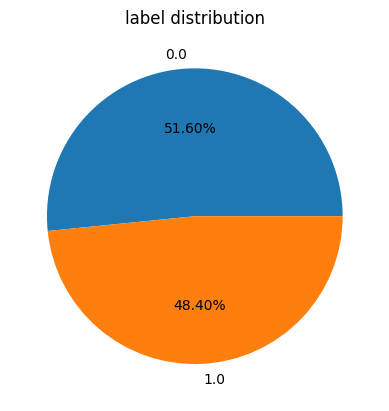

In [ ]:
display_class_pie_distribution(len_check_merged_fake_true_ds,'label')

In [ ]:
clean_fake_ture_ds = len_check_merged_fake_true_ds.drop(columns='date')

In [ ]:
clean_text_by_nfx_filter(clean_fake_ture_ds, 'text')
lowcase_fake_ture_ds = text_low_standarization(clean_fake_ture_ds)
change_col_to_string(lowcase_fake_ture_ds)
lowcase_fake_ture_ds = lowcase_fake_ture_ds.sample(frac=1).reset_index(drop=True)
lowcase_fake_ture_ds

<ipython-input-12-a2dbb60a2f9e>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')
<ipython-input-12-a2dbb60a2f9e>:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ds.loc[:,(col)]= ds.loc[:,(col)].apply(lambda x: x.lower())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 44244 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   title       44244 non-null  string 
 1   text        44244 non-null  string 
 2   subject     44244 non-null  string 
 3   label       44244 non-null  float64
 4   clean_text  44244 non-null  string 
dtypes: float64(1), string(4)
memory usage: 2.0 MB


<ipython-input-12-a2dbb60a2f9e>:81: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')


,title,text,subject,label,clean_text
0,"‘trump, russia, possible collusion’ (remix)",russiagate. first it was russian hacking our e...,us_news,0.0,russiagate russian hacking election russian in...
1,news legend dan rather just razed trump’s hat...,trump s first immigration speech following his...,news,0.0,trump immigration speech following humiliation...
2,obama releases 15 more dangerous terrorists to...,osama bin laden s bodyguard and 14 other terro...,government news,0.0,osama laden bodyguard terrorists released toda...
3,defense secretary mattis promises support to u...,kiev (reuters) - u.s. defense secretary jim ma...,worldnews,1.0,kiev reuters defense secretary mattis visit uk...
4,angola's ruling mpla wins election with 61 per...,luanda (reuters) - angola s ruling mpla party ...,worldnews,1.0,luanda reuters angola ruling mpla party genera...
...,...,...,...,...,...
44239,big banks' relationship with dodd-frank: it's ...,(reuters) - having spent billions of dollars o...,politicsnews,1.0,reuters spent billions dollars postcrisis fina...
44240,u.s. government delays obama earnings-strippin...,washington (reuters) - the u.s. government on ...,politicsnews,1.0,washington reuters government friday gave comp...
44241,breaking bombshell: obama’s foreign policy gur...,"as if this news, in and of itself, is not horr...",left-news,0.0,news horrific deputy national security advisor...
44242,trump resists pressure to soften stance on ira...,washington (reuters) - president donald trump ...,worldnews,1.0,washington reuters president donald trump find...


## DF2 (wel_fake)

In [ ]:
wel_fake = pd.read_csv(wel_fake_ds_path, index_col=0)
wel_fake.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


In [ ]:
wel_fake_no_null = ds_wo_null(wel_fake)
wel_fake_no_null = wel_fake_no_null.reset_index(drop=True)
wel_fake_no_null = min_column_len_filter(wel_fake_no_null, 'text', words_len)
wel_fake_no_null = wel_fake_no_null.reset_index(drop= True)
clean_text_by_nfx_filter(wel_fake_no_null, 'text')

,title,text,label,clean_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,comment expected barack obama members fukyofla...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,demonstrators gathered night exercising consti...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,dozen politically active pastors came private ...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,sarmat missile dubbed satan replace flies mile...
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,time sued southern poverty centeron tuesday ja...
...,...,...,...,...
70763,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,washington reuters hackers believed working ru...
70764,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,know fantasyland republicans questioned citize...
70765,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,migrants refuse leave train refugee camp hunga...
70766,Trump tussle gives unpopular Mexican leader mu...,MEXICO CITY (Reuters) - Donald Trump’s combati...,0,mexico city reuters donald trumps combative st...


<ipython-input-12-a2dbb60a2f9e>:31: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')
<ipython-input-12-a2dbb60a2f9e>:32: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ds.loc[:,(col)]= ds.loc[:,(col)].apply(lambda x: x.lower())


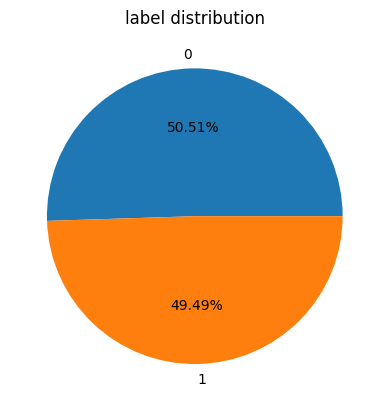

In [ ]:
lowcase_wel_ds = text_low_standarization(wel_fake_no_null)
display_class_pie_distribution(wel_fake_no_null,'label')

In [ ]:
change_col_to_string(lowcase_wel_ds)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70768 entries, 0 to 70767
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       70768 non-null  string
 1   text        70768 non-null  string
 2   label       70768 non-null  int64 
 3   clean_text  70768 non-null  string
dtypes: int64(1), string(3)
memory usage: 2.2 MB


<ipython-input-12-a2dbb60a2f9e>:81: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')


In [ ]:
lowcase_wel_ds = lowcase_wel_ds.reset_index(drop=True)

# Modeling

## DF1

### Raw text only in lowcase

In [ ]:
lowcase_fake_ture_ds[['text', 'label']]

,text,label
0,russiagate. first it was russian hacking our e...,0.0
1,trump s first immigration speech following his...,0.0
2,osama bin laden s bodyguard and 14 other terro...,0.0
3,kiev (reuters) - u.s. defense secretary jim ma...,1.0
4,luanda (reuters) - angola s ruling mpla party ...,1.0
...,...,...
44239,(reuters) - having spent billions of dollars o...,1.0
44240,washington (reuters) - the u.s. government on ...,1.0
44241,"as if this news, in and of itself, is not horr...",0.0
44242,washington (reuters) - president donald trump ...,1.0


In [ ]:
X_train_DF1_text, X_test_DF1_text, y_train_DF1_text, y_test_DF1_text = train_test_split(
                                                    lowcase_fake_ture_ds.text,
                                                    lowcase_fake_ture_ds.label,
                                                    test_size = 0.1, shuffle = True)
X_train_DF1_text, X_val_DF1_text, y_train_DF1_text, y_val_DF1_text = train_test_split(X_train_DF1_text,
                                                    y_train_DF1_text,
                                                    test_size = 0.1, shuffle = True)

In [ ]:
bow_DF1_text = CountVectorizer(ngram_range=(1,2), max_features = 5_000)
X_train_encoded_DF1_text = bow_DF1_text.fit_transform(X_train_DF1_text)
log_reg_DF1_text = LogisticRegression(max_iter=5_000)

#### Train

In [ ]:
log_reg_DF1_text.fit(X_train_encoded_DF1_text, y_train_DF1_text)
log_reg_DF1_text.score(X_train_encoded_DF1_text, y_train_DF1_text)*100

100.0

#### Test

In [ ]:
X_test__DF1_enc_text = bow_DF1_text.transform(X_test_DF1_text)
y_pred_DF1_text = log_reg_DF1_text.predict(X_test__DF1_enc_text)
print(classification_report(y_true = y_test_DF1_text, y_pred = y_pred_DF1_text))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2295
         1.0       1.00      0.99      1.00      2130

    accuracy                           1.00      4425
   macro avg       1.00      1.00      1.00      4425
weighted avg       1.00      1.00      1.00      4425



In [ ]:
tested_text = lowcase_fake_ture_ds[['text','label']].sample(1)
tested_text

,text,label
1839,hillary would never have labeled one of her la...,0.0


#### Validation

In [ ]:
val_DF1_enc_text = bow_DF1_text.transform(X_val_DF1_text)
pred_val_DF1_text = log_reg_DF1_text.predict(val_DF1_enc_text)
print(classification_report(y_true = y_val_DF1_text, y_pred = pred_val_DF1_text))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2031
         1.0       1.00      0.99      1.00      1951

    accuracy                           1.00      3982
   macro avg       1.00      1.00      1.00      3982
weighted avg       1.00      1.00      1.00      3982



#### Demo

In [ ]:
tested_text = lowcase_fake_ture_ds[['text','label']].sample(1)
tested_text

,text,label
23269,watch: @realdonaldtrump exits his speech in ca...,0.0


In [ ]:
print_news_autentication_predict_ml(bow_DF1_text,
                                    tested_text.text,
                                    log_reg_DF1_text)

Tested text: "23269    watch: @realdonaldtrump exits his speech in ca......" 

NEWS IS FAKE 
with confidence: 99.999%


### Pytorch NNR

In [ ]:
train_value = round(len(lowcase_fake_ture_ds)*0.9)
train_pt = lowcase_fake_ture_ds[:train_value]
test_pt = lowcase_fake_ture_ds[train_value:]

In [ ]:
DF1_train = Sequences(train_pt, 'text', 'label')
DF1_test = Sequences(test_pt, 'text', 'label')
train_loader = DataLoader(DF1_train, batch_size=round(train_value*0.1))

In [ ]:
PT_model_DF1 = BagOfWordsClassifier(len(DF1_train.token2idx), 64, 32)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam([p for p in PT_model_DF1.parameters() if p.requires_grad], lr=0.01)

#### Train

In [ ]:
training_pt_model(PT_model_DF1,
                  train_loader,
                  criterion,
                  optimizer,
                  20)

<ipython-input-12-a2dbb60a2f9e>:140: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.25928


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.05700


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.02580


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.01092


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.00509


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.00438


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.00451


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.01420


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.00813


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.02300


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.04102


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #12	Train Loss: 0.04771


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #13	Train Loss: 0.01774


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #14	Train Loss: 0.00519


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #15	Train Loss: 0.00232


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #16	Train Loss: 0.00133


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #17	Train Loss: 0.00069


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #18	Train Loss: 0.00028


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #19	Train Loss: 0.00050


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #20	Train Loss: 0.00044


#### DEMO

In [ ]:
sample_text_demo = test_pt[['text', 'label']].sample(1)
sample_text_demo

,text,label
43999,21st century wire says did mitt romney just ma...,0.0


In [ ]:
print_predict_news_autentication(sample_text_demo['text'],
                           PT_model_DF1,
                           DF1_train)

Conficence of prediction: 1e+02% 
Fake news


### clean text 

In [ ]:
X_train_DF1_clean, X_test_DF1_clean, y_train_DF1_clean, y_test_DF1_clean = train_test_split(
                                                    lowcase_fake_ture_ds.clean_text,
                                                    lowcase_fake_ture_ds.label,
                                                    test_size = 0.1, shuffle = True)

#### Train

In [ ]:
bow_DF1_clean = CountVectorizer(ngram_range=(1,2), max_features = 5_000)
X_train_encoded_DF1_clean = bow_DF1_clean.fit_transform(X_train_DF1_clean)
log_reg_DF1_clean = LogisticRegression(max_iter=5_000)
log_reg_DF1_clean.fit(X_train_encoded_DF1_clean, y_train_DF1_clean)
log_reg_DF1_clean.score(X_train_encoded_DF1_clean, y_train_DF1_clean)*100

100.0

#### Test

In [ ]:
X_test__DF1_enc_clean = bow_DF1_clean.transform(X_test_DF1_clean)
y_pred_DF1_clean = log_reg_DF1_clean.predict(X_test__DF1_enc_clean)
print(classification_report(y_true = y_test_DF1_clean, y_pred = y_pred_DF1_clean))

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      2249
         1.0       1.00      0.99      1.00      2176

    accuracy                           1.00      4425
   macro avg       1.00      1.00      1.00      4425
weighted avg       1.00      1.00      1.00      4425



#### Demo

In [ ]:
tested_text = lowcase_fake_ture_ds[['text','label']].sample(1)
display(tested_text)
print()
print_news_autentication_predict_ml(bow_DF1_clean,
                                    tested_text.text,
                                    log_reg_DF1_clean)

,text,label
40432,how very charitable of the lutheran and cath...,0.0



Tested text: "40432    how very  charitable  of the lutheran and cath......" 

NEWS IS FAKE 
with confidence: 100.000%


### Lematize

In [ ]:
bow_DF1_lem = CountVectorizer(analyzer=process_text)
X_train_vec_lem = bow_DF1_lem.fit_transform(X_train_DF1_text)

In [ ]:
log_reg_DF1_lem = LogisticRegression(max_iter=5_000)
log_reg_DF1_lem.fit(X_train_vec_lem, X_train_DF1_text)
log_reg_DF1_lem.score(X_train_vec_lem, X_train_DF1_text)*100

In [ ]:
X_test__DF1_enc_lem = bow_DF1_lem.transform(X_test_DF1_text)
y_pred_DF1_lem = log_reg_DF1_lem.predict(X_test__DF1_enc_lem)
print(classification_report(y_true = y_test_DF1_text, y_pred = y_pred_DF1_lem))

## DF2

### Raw text only in lowcase

In [ ]:
lowcase_wel_ds

,title,text,label,clean_text
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1,comment expected barack obama members fukyofla...
1,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last ...",1,demonstrators gathered night exercising consti...
2,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0,dozen politically active pastors came private ...
3,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1,sarmat missile dubbed satan replace flies mile...
4,about time! christian group sues amazon and sp...,all we can say on this one is it s about time ...,1,time sued southern poverty centeron tuesday ja...
...,...,...,...,...
70763,russians steal research on trump in hack of u....,washington (reuters) - hackers believed to be ...,0,washington reuters hackers believed working ru...
70764,watch: giuliani demands that democrats apolog...,"you know, because in fantasyland republicans n...",1,know fantasyland republicans questioned citize...
70765,migrants refuse to leave train at refugee camp...,migrants refuse to leave train at refugee camp...,0,migrants refuse leave train refugee camp hunga...
70766,trump tussle gives unpopular mexican leader mu...,mexico city (reuters) - donald trump’s combati...,0,mexico city reuters donald trumps combative st...


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lowcase_wel_ds.text,
                                                    lowcase_wel_ds['label'],
                                                    test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size = 0.1)

#### Train

In [ ]:
bow = CountVectorizer(ngram_range=(1,2), max_features=5_000)
X_train_encoded = bow.fit_transform(X_train)
log_reg = LogisticRegression(max_iter=5_000)
log_reg.fit(X_train_encoded, y_train)
log_reg.score(X_train_encoded, y_train)*100

99.51152282758501

#### Test

In [ ]:
X_test_enc = bow.transform(X_test)
y_pred = log_reg.predict(X_test_enc)
print(classification_report(y_true = y_test, y_pred = y_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      3551
           1       0.94      0.96      0.95      3526

    accuracy                           0.95      7077
   macro avg       0.95      0.95      0.95      7077
weighted avg       0.95      0.95      0.95      7077



#### Demo

In [ ]:
tested_text = lowcase_wel_ds[['text','label']].sample(1)
display(tested_text)
print()
print_news_autentication_predict_ml(bow,
                                    tested_text.text,
                                    log_reg)

,text,label
33513,"on saturday, illinois newspaper, the bellevill...",1



Tested text: "33513    on saturday, illinois newspaper, the bellevill......" 

NEWS IS REAL 
with confidence: 100.000%


### Pytorch

In [ ]:
train_value_DF2 = round(len(lowcase_wel_ds)*0.95)
train_pt_DF2 = lowcase_wel_ds[:train_value_DF2]
test_pt_DF2 = lowcase_wel_ds[train_value_DF2:]

DF2_train = Sequences(train_pt_DF2, 'text', 'label')
DF2_test = Sequences(test_pt_DF2, 'text', 'label')
train_loader_DF2 = DataLoader(DF2_train, batch_size = round(train_value_DF2*0.1))

In [ ]:
PT_model_DF2 = BagOfWordsClassifier(len(DF2_train.token2idx), 64, 32)
criterion_DF2 = nn.BCEWithLogitsLoss()
optimizer_DF2 = optim.Adam([p for p in PT_model_DF2.parameters() if p.requires_grad], lr=0.01)

#### Train

In [ ]:
training_pt_model(PT_model_DF2,
                  train_loader_DF2,
                  criterion_DF2,
                  optimizer_DF2,
                  50)

<ipython-input-12-a2dbb60a2f9e>:140: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.46755


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #2	Train Loss: 0.23348


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #3	Train Loss: 0.14382


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #4	Train Loss: 0.09542


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #5	Train Loss: 0.06256


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #6	Train Loss: 0.05459


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #7	Train Loss: 0.06613


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #8	Train Loss: 0.03922


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #9	Train Loss: 0.02242


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #10	Train Loss: 0.01265


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.01074


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #12	Train Loss: 0.00968


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #13	Train Loss: 0.01229


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #14	Train Loss: 0.01330


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #15	Train Loss: 0.01337


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #16	Train Loss: 0.01551


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #17	Train Loss: 0.01630


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #18	Train Loss: 0.02495


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #19	Train Loss: 0.02552


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #20	Train Loss: 0.02941


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.02966


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #22	Train Loss: 0.02766


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #23	Train Loss: 0.04326


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #24	Train Loss: 0.03926


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #25	Train Loss: 0.02481


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #26	Train Loss: 0.01222


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #27	Train Loss: 0.00422


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #28	Train Loss: 0.00204


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #29	Train Loss: 0.00123


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #30	Train Loss: 0.00084


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.00064


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #32	Train Loss: 0.00052


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #33	Train Loss: 0.00044


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #34	Train Loss: 0.00037


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #35	Train Loss: 0.00032


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #36	Train Loss: 0.00031


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #37	Train Loss: 0.00025


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #38	Train Loss: 0.00026


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #39	Train Loss: 0.00022


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #40	Train Loss: 0.00021


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #41	Train Loss: 0.00027


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #42	Train Loss: 0.00059


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #43	Train Loss: 0.00039


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #44	Train Loss: 0.00020


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #45	Train Loss: 0.00023


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #46	Train Loss: 0.00019


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #47	Train Loss: 0.00017


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #48	Train Loss: 0.00017


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #49	Train Loss: 0.00015


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch #50	Train Loss: 0.00013


#### Demo

In [ ]:
sample_text_demo_DF2 = test_pt_DF2[['text', 'label']].sample(1)
sample_text_demo_DF2

,text,label
69620,boston/new york (reuters) - supporters of u.s....,0


In [ ]:
print_predict_news_autentication(sample_text_demo_DF2.text, PT_model_DF2, DF2_train)

Conficence of prediction: 1e+02% 
Fake news


### clean text 

In [ ]:
X_train_DF2_clean, X_test_DF2_clean, y_train_DF2_clean, y_test_DF2_clean = train_test_split(
                                                    lowcase_wel_ds.clean_text,
                                                    lowcase_wel_ds.label,
                                                    test_size = 0.1, shuffle = True)

In [ ]:
bow_DF2_clean = CountVectorizer(ngram_range=(1,2), max_features = 5_000)
X_train_encoded_DF2_clean = bow_DF2_clean.fit_transform(X_train_DF2_clean)
log_reg_DF2_clean = LogisticRegression(max_iter=5_000)
log_reg_DF2_clean.fit(X_train_encoded_DF2_clean, y_train_DF2_clean)

LogisticRegression(max_iter=5000)

In [ ]:
log_reg_DF2_clean.score(X_train_encoded_DF2_clean, y_train_DF2_clean)*100

98.11590334584164

In [ ]:
X_test__DF2_enc_clean = bow_DF2_clean.transform(X_test_DF2_clean)
y_pred_DF2_clean = log_reg_DF2_clean.predict(X_test__DF2_enc_clean)
print(classification_report(y_true = y_test_DF2_clean, y_pred = y_pred_DF2_clean))

              precision    recall  f1-score   support

           0       0.96      0.93      0.94      3573
           1       0.93      0.96      0.94      3504

    accuracy                           0.94      7077
   macro avg       0.94      0.94      0.94      7077
weighted avg       0.94      0.94      0.94      7077



#### Demo

In [ ]:
tested_text = lowcase_wel_ds[['text','label']].sample(1)
display(tested_text)
print()
print_news_autentication_predict_ml(bow_DF2_clean,
                                    tested_text.text,
                                    log_reg_DF2_clean)

,text,label
40719,thursday on fox news channel’s “america’s news...,0



Tested text: "40719    thursday on fox news channel’s “america’s news......" 

NEWS IS FAKE 
with confidence: 92.906%
